In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"neenamaryalex","key":"e428483a572b398502b259d40a37f628"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d alifrahman/chestxraydataset

100% 1.14G/1.14G [00:41<00:00, 32.7MB/s]
100% 1.14G/1.14G [00:41<00:00, 29.4MB/s]


In [3]:
!unzip /content/chestxraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0419-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0420-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0421-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0423-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0424-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0425-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0427-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0428-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0430-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0431-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0432-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0433-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0434-0001.jpeg  
  inflating: chest_xray/tra

In [11]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model


import numpy as np
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import cv2

In [12]:
f = open("result.txt","a")

In [13]:
def Build_CNN_Model():
    
    # -------------------------------------------------------------------------
    # -------------------------------------------------------------------------
    # load Inception model
    Inception = InceptionV3(include_top=True, input_shape=(299, 299, 3))

    # mark loaded layers as trainable
    for layer in Inception.layers:
	    layer.trainable = True      
	
  
    #  Softmax Classifier
    Class_layer = Dense(2)(Inception.layers[-2].output)
    
    Softmax_layer = Activation('softmax')(Class_layer)
    
    
	# define new model    
    model = Model(inputs=Inception.inputs, outputs=Softmax_layer)
    
        
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 

In [14]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
   
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('/content/chest_xray/train',batch_size=batch_size, target_size=(299, 299))
    valid_it = valid_datagen.flow_from_directory('/content/chest_xray/test',batch_size=batch_size, target_size=(299, 299))


    epochs=25;
    
    history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')

In [15]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/content/chest_xray/test',#classes =('normal','abnormal'), 
                                               shuffle=False,batch_size=batch_size, target_size=(299, 299))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));

    f.write(confusion_matrix(y_true,y_pred_binary))
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)

    f.write('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)

    f.write('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)

    f.write('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1) 

    f.write('F1 score: %f' % f1)
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    f.write('ROC AUC: %f' % auc)


    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()

In [16]:
model = Build_CNN_Model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/25
163/163 [==============================] - 218s 1s/step - loss: 0.2265 - accuracy: 0.9114 - val_loss: 1.3877 - val_accuracy: 0.6699
Epoch 2/25
163/163 [==============================] - 201s 1s/step - loss: 0.1171 - accuracy: 0.9592 - val_loss: 1.0652 - val_accuracy: 0.7756
Epoch 3/25
163/163 [==============================] - 201s 1s/step - loss: 0.1060 - accuracy: 0.9626 - val_loss: 0.7355 - val_accuracy: 0.7837
Epoch 4/25
163/163 [==============================] - 203s 1s/step - loss: 0.0871 - accuracy: 0.9705 - val_loss: 0.3137 - val_accuracy: 0.9151
Epoch 5/25
163/163 [==============================] - 199s 1s/step - loss: 0.0680 - accuracy: 0.9745 - val_loss: 0.3787 - val_accuracy: 0.8734
Epoch 6/25
163/163 [==============================] - 197s 1s/step - loss: 0.0737 - accuracy: 0.9732 - val_loss: 0.4233 - val_accuracy: 0.8349
Epoch 7/25
163/163 [==============================] - 197s 

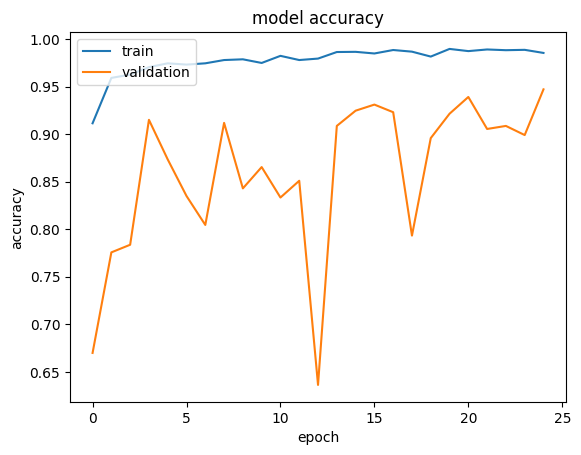

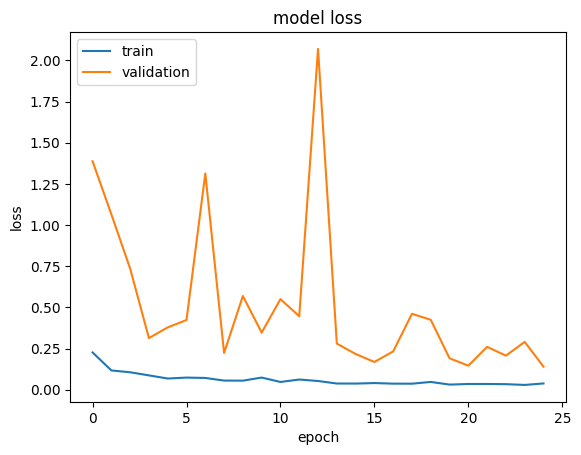

In [17]:


Train_CNN_Model(model)



    


In [ ]:
img = plt.imread('/content/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg')
img = cv2.resize(img, (299, 299))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
result = classifier.predict(np.expand_dims(image.img_to_array(img), axis = 0))  

if result[0][0] > 0.5:
  prediction = 'Pnuemonia'
else:
  prediction = 'Normal'
  
print(prediction)
f.write(prediction)

FileNotFoundError: ignored

In [18]:
Evaluate_CNN_Model()

Found 624 images belonging to 2 classes.


<ipython-input-15-39570f924322>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)


20/20 [==============================] - 9s 362ms/step

Confusion Matrix
 -------------------------
[[209  25]
 [  8 382]]


TypeError: ignored